# 第3章 word2vec

本章依然是词向量的分布式表示

不过介绍另一种方法

## 基于推理的方法和神经网络

### 基于计数方法的问题

基于计数：SVD，比如英语，100 万 × 100 万的庞大矩阵，执行 SVD 不现实

基于推理：使用神经网络，通常在mini-batch上学习

### 基于推理方法的概要


基于推理：使用神经网络，通常在mini-batch上学习

![](./img/3-1.png)

基于推理的思想：给出上下文，猜中间这个词，类似完型填空

![](./img/3-2.png)

计算过程

![](./img/3-3.png)

训练：给上下文，给正确答案，得到模型

预测：个上下文，得到概率分布

### 神经网络中单词的处理方法

词向量的几种表示方式

![](./img/3-4.png)

我们需要使用one-hot表示方法

此时输入层的情况

![](./img/3-5.png)

输入层的个数 = 单词的个数

查看 全连接层 H = XW

![](./img/3-6.png)

In [1]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 输入
W = np.random.randn(7, 3) # 权重
h = np.dot(c, W) # 中间节点
print(h)

[[ 0.51951525 -0.35136917 -0.30513129]]


这里我们全部省略偏置

![](./img/3-8.png)

观察这里可以看出，W的每一行对应一个单词

In [2]:
import sys
import numpy as np
from common.layers import MatMul
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 2.49232519 -0.49138191 -0.85094725]]


## 简单的word2vec

### CBWO模型的推理

![](./img/3-9.png)

计算图如下

![](./img/3-11.png)

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul
# 样本的上下文数据
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])
# 权重的初始值
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)
# 生成层
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)
# 正向传播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-1.33432124 -0.22532353 -0.38884368 -0.50979993  2.38410366  0.38352408
   0.96907467]]


### CBWO模型的学习

加入Softmax

![](./img/3-12.png)

加入交叉熵误差

![](./img/3-13.png)

这两个合并成一个层

![](./img/3-14.png)

### word2vec的权重和分布式表示

 Win 的每一行对应于各个单词的分布式表示。
 
 Wout 也同样保存了对单词含义进行了编码的向量，在列方向上对应了各个单词的分布式表示。

![](./img/3-15.png)

那么，我们最终应该使用哪个权重作为单词的分布式表示呢？这里有三个选项。

A. 只使用输入侧的权重

B. 只使用输出侧的权重

C. 同时使用两个权重

方案 A 和方案 B 只使用其中一个权重。

而在采用方案 C 的情况下，根据如何组合这两个权重，存在多种方式，其中一个方式就是简单地将这两个权重相加。

就 word2vec（特别是 skip-gram 模型）而言，最受欢迎的是方案 A。

许多研究中也都仅使用输入侧的权重 Win 作为最终的单词的分布式表示。

遵循这一思路，我们也使用 Win 作为单词的分布式表示

## 学习数据的准备

### 上下文和目标词

就从语料库生成上下文和目标词
![](./img/3-16.png)

In [4]:
import sys
sys.path.append('..')
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


从单词 ID 列表 corpus 生成 contexts 和 target。

![](./img/3-17.png)

In [5]:
# common/util.py
def create_contexts_target(corpus, window_size=1):
    # 一个是单词 ID 列表（corpus）；另一个是上下文的窗口大小（window_size）。
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [6]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [7]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [8]:
target

array([1, 2, 3, 4, 1, 5])

### 转化为one-hot表示

![](./img/3-18.png)

In [9]:
def convert_one_hot(corpus, vocab_size):
    '''转换为one-hot表示

    :param corpus: 单词ID列表（一维或二维的NumPy数组）
    :param vocab_size: 词汇个数
    :return: one-hot表示（二维或三维的NumPy数组）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [10]:
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [11]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]])

In [12]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]])

## CBOW模型的实现

![](./img/3-19.png)

In [13]:
# ch03/simple_cbow.py

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        ## 我们指定 NumPy 数组的数据类型为 astype('f')，初始化将使用 32 位的浮点数。
        
        # 生成层
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


![](./img/3-20.png)

学习的实现

In [14]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target,convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 259 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 260 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 261 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 262 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 263 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 264 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 265 |  iter 1 / 2 | time 0[s] | loss 1.31
| epoch 266 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 267 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 268 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 269 |  iter 1 / 2 | time 0[s] | loss 1.30
| epoch 270 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 271 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 272 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 273 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 274 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 275 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 276 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 277 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 278 |  iter 1 / 2 | time 0[s] | loss 1.20


| epoch 525 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 526 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 527 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 528 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 529 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 530 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 531 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 532 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 533 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 534 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 535 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 536 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 537 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 538 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 539 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 540 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 541 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 542 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 543 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 544 |  iter 1 / 2 | time 0[s] | loss 0.75


| epoch 810 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 811 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 812 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 813 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 814 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 815 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 816 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 817 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 818 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 819 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 820 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 821 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 822 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 823 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 824 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 825 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 826 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 827 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 828 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 829 |  iter 1 / 2 | time 0[s] | loss 0.49


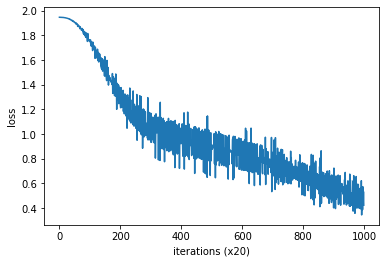

In [15]:
trainer.plot()

In [16]:
word_vecs = model.word_vecs
word_vecs

array([[ 9.8249644e-01, -8.5833055e-01, -1.6273881e+00, -8.3720165e-01,
         1.5045615e+00],
       [-1.2812319e+00,  1.3110808e+00, -8.7866598e-01,  1.0851197e+00,
         1.1270859e+00],
       [ 1.0270251e+00, -1.1239169e+00,  5.7423646e-03, -1.2175992e+00,
         1.3867971e-01],
       [ 8.8527596e-01,  1.1560804e+00, -1.5801679e+00,  1.6953762e+00,
         6.4786702e-01],
       [ 1.0355864e+00, -1.1164038e+00,  7.7242870e-04, -1.2073808e+00,
         1.6012776e-01],
       [ 9.6382952e-01, -8.7047106e-01, -1.6310581e+00, -8.3580989e-01,
         1.4927622e+00],
       [-1.7909030e+00,  1.0794820e+00,  6.4835131e-01, -8.5396254e-01,
         1.3498298e+00]], dtype=float32)

In [17]:
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.98249644 -0.85833055 -1.6273881  -0.83720165  1.5045615 ]
say [-1.2812319  1.3110808 -0.878666   1.0851197  1.1270859]
goodbye [ 1.0270251  -1.1239169   0.00574236 -1.2175992   0.13867971]
and [ 0.88527596  1.1560804  -1.5801679   1.6953762   0.647867  ]
i [ 1.0355864e+00 -1.1164038e+00  7.7242870e-04 -1.2073808e+00
  1.6012776e-01]
hello [ 0.9638295  -0.87047106 -1.6310581  -0.8358099   1.4927622 ]
. [-1.790903    1.079482    0.6483513  -0.85396254  1.3498298 ]


我们终于将单词表示为了密集向量！这就是单词的分布式表示。

我们有理由相信，这样的分布式表示能够很好地捕获单词含义

下一章我们使用大的语料库，应该能获得更好的结果

## word2vec的补充说明

### CBOW模型和概率

![](./img/3-22.png)

 wt−1 和 wt+1 发生后，wt 发生的概率

![](./img/3.1.png)

“wt 发生”这一事件是正确解，它对应的 one-hot 向量的元素是 1，其他元素都是 0

则损失函数

![](./img/3.2.png)

上面是一笔样本数据的损失函数。

如果将其扩展到整个语料库，则损失函数可以写为：

![](./img/3.3.png)

### skip-gram模型

如前所述，word2vec 有两个模型：

一个是我们已经讨论过的 CBOW模型；

另一个是被称为 skip-gram 的模型。

skip-gram 是反转了 CBOW 模型处理的上下文和目标词的模型。

![](./img/3-23.png)

此时，skip-gram 模型的网络结构如图 

![](./img/3-24.png)

kip-gram 模型的输入层只有一个，输出层的数量则与上下文的单词个数相等。

因此，首先要分别求出各个输出层的损失（通过Softmax with Loss 层等），然后将它们加起来作为最后的损失。

用概率表示

![](./img/3.4.png)

当给定 wt 时，wt−1 和 wt+1 同时发生的概率

![](./img/3.5.png)

代入交叉熵误差函数，可以推导出 skip-gram 模型的损失函数

![](./img/3.6.png)

这里利用了对数的性质 log xy = log x + log y

skip-gram 模型的损失函数先分别求出各个上下文对应的损失，然后将它们加在一起。

式 (3.6) 是一笔样本数据的损失函数。

如果扩展到整个语料库，则skip-gram 模型的损失函数可以表示为

![](./img/3.7.png)

比较式 (3.7) 和 CBOW 模型的式 (3.3)，差异是非常明显的。

因为 skip-gram 模型的预测次数和上下文单词数量一样多，所以它的损失函数需要求各个上下文单词对应的损失的总和。

而CBOW模型只需要求目标词的损失。

以上就是对 skip-gram 模型的介绍。

### CBOW vs skip-gram

那么，我们应该使用 CBOW 模型和 skip-gram 模型中的哪一个呢？

答案应该是 skip-gram 模型。

这是因为，从单词的分布式表示的准确度来看，在大多数情况下，skip-grm 模型的结果更好。

特别是随着语料库规模的增大，在低频词和类推问题的性能方面，skip-gram 模型往往会有更好的表现（单词的分布式表示的评价方法会在 4.4.2 节说明）。


skip-gram 模型根据一个单词预测其周围的单词，这是一个非常难的问题。

假如我们来解决图 3-23 中的问题，此时，对于 CBOW 模型的问题，我们很容易回答“say”。

但是，对于 skip-gram 模型的问题，则存在许多候选。

因此，可以说 skip-gram 模型要解决的是更难的问题。

经过这个更难的问题的锻炼，skip-gram 模型能提供更好的单词的分布式表示。

此外，就学习速度而言，CBOW 模型比 skip-gram 模型要快。这是因为 skip-gram 模型需要根据上下文数量计算相应个数的损失，计算成本变大。

### 基于计数与基于推理

首先，我们考虑需要向词汇表添加新词并更新单词的分布式表示的场景。

此时，基于计数的方法需要从头开始计算。即便是想稍微修改一下单词的分布式表示，也需要重新完成生成共现矩阵、进行 SVD 等一系列操作。

相反，基于推理的方法（word2vec）允许参数的增量学习。

具体来说，可以将之前学习到的权重作为下一次学习的初始值，在不损失之前学习到的经验的情况下，高效地更新单词的分布式表示。

在这方面，基于推理的方法（word2vec）具有优势

其次，两种方法得到的单词的分布式表示的性质和准确度有什么差异呢？

就分布式表示的性质而言，基于计数的方法主要是编码单词的相似性，而 word2vec（特别是 skip-gram 模型）除了单词的相似性以外，还能理解更复杂的单词之间的模式。

关于这一点，word2vec 因能解开“king −man + woman = queen”这样的类推问题而知名（关于类推问题，我们将在 4.4.2 节说明）。


这里有一个常见的误解，那就是基于推理的方法在准确度方面优于基于计数的方法。

实际上，有研究表明，就单词相似性的定量评价而言，基于推理的方法和基于计数的方法难分上下

<div class="alert alert-success" role="alert">
    <strong>澄清！！</strong> 
2014 年发表的题为“Don’t count, predict!”（不要计数，要预测！）
的论文 [24] 系统地比较了基于计数的方法和基于推理的方法，并给
出了基于推理的方法在准确度上始终更好的结论。但是，之后又有
其他的论文 [25]提出，就单词的相似性而言，结论高度依赖于超参数，
基于计数的方法和基于推理的方法难分胜负。

另外一个重要的事实是，基于推理的方法和基于计数的方法存在关联性。

具体地说，使用了 skip-gram 和下一章介绍的 Negative Sampling 的模型被证明与对整个语料库的共现矩阵（实际上会对矩阵进行一定的修改）进行特殊矩阵分解的方法具有相同的作用 [26]。

换句话说，这两个方法论（在某些条件下）是“相通”的。

此外，在 word2vec 之后，有研究人员提出了 GloVe 方法 [27]。

GloVe方法融合了基于推理的方法和基于计数的方法。

该方法的思想是，将整个语料库的统计数据的信息纳入损失函数，进行 mini-batch 学习（具体请参考论文 [27]）。

据此，这两个方法论成功地被融合在了一起。

## 小结

托马斯·米科洛夫（Tomas Mikolov）在一系列论文 [22] [23] 中提出了word2vec。

自论文发表以来，word2vec 受到了许多关注，它的作用也在许多自然语言处理任务中得到了证明。下一章，我们将结合具体的例子来说明word2vec 的重要性，特别是 word2vec 的迁移学习的作用。

本章我们详细解释了 word2vec 的 CBOW 模型，并对其进行了实现。

CBOW 模型基本上是一个 2 层的神经网络，结构非常简单。

我们使用MatMul 层和 Softmax with Loss 层构建了 CBOW 模型，并用一个小规模语料库确认了它的学习过程。遗憾的是，现阶段的 CBOW 模型在处理效率上还存在一些问题。

不过，在理解了本章的 CBOW 模型之后，离真正的word2vec 也就一步之遥了。

下一章，我们将改进 CBOW 模型。